## ARIMA Model -- Time Series Forecasting

In this notebook, the objective is to examine a time dependent dataset. Serial correlation occurs when the course of a time series is influenced by its recent history. Let's first start off by looking at the *Autoregressive Integrated Moving Average Model* (ARIMA).


- **AR: Autoregression** -- A model that uses the dependent relationship between an observation and some number of lagged observations


- **I: Integrated** -- The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary


- **MA: Moving Average** -- A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

### Import Python Packages

In [1]:
import pandas as pd
import quandl
import datetime as dt
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline

### Get WTI Data

- Access for API Key: https://docs.quandl.com/
- WTI Data: https://www.quandl.com/data/EIA/PET_RWTC_D-Cushing-OK-WTI-Spot-Price-FOB-Daily

Dimensions: (4209, 1)
Start Date:  2001-01-02 00:00:00
End Date:  2017-09-18 00:00:00

Last Recorded WTI Price ($ USD):  49.88
Last Recorded Date:  2017-09-18


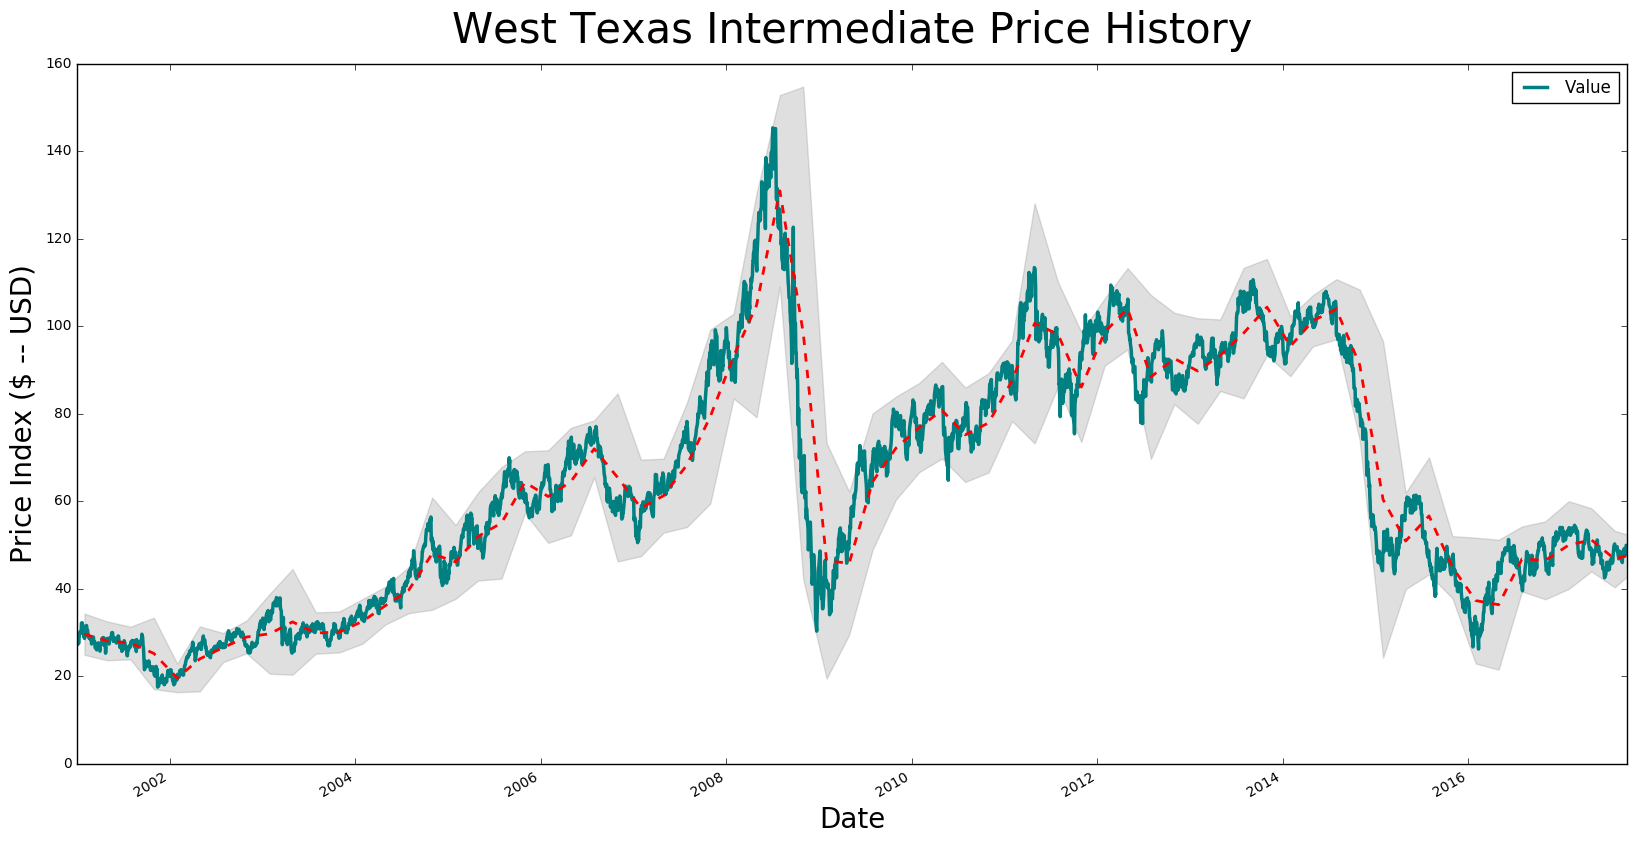

In [2]:
def get_wti(start_date='2001-1-1'):
    raw = quandl.get("EIA/PET_RWTC_D", returns="pandas",api_key='3nkyMDezTtKeAh7DfVqd',
          start_date=start_date, end_date=dt.date.today())  
    
    print('Dimensions:',raw.shape)
    print('Start Date: ',raw.index.min())
    print('End Date: ',raw.index.max())
    
    print('\n======================================')
    print('Last Recorded WTI Price ($ USD): ',float(raw.iloc[-1]))
    print('Last Recorded Date: ',raw.index[-1].date())
    print('======================================')
    return(raw)

def wti_history(df,window=90,std=3):
    
    #Compute Statistics
    agg = df.resample('3M').agg(['mean','std'])
    agg.columns = ['{}_{}'.format(col[0],col[1]) for col in agg.columns]
    
    #Set up Visualization
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    #Plot Raw Data
    df.plot(lw=2.5,c='teal',ax=ax)
    
    #Plot Rolling Mean
    ax.plot(agg.ix[:,0],color='red',lw=2.0,ls='--')
    
    #Plot Upper/Lower Bands
    ax.fill_between(agg.index, agg.ix[:,0] - std*agg.ix[:,1], agg.ix[:,0] + std*agg.ix[:,1],alpha=.25,color='grey')
        
    ax.set_ylabel('Price Index ($ -- USD)',fontsize=20)
    ax.set_xlabel('Date',fontsize=20)
    ax.set_title('West Texas Intermediate Price History',fontsize=30,y=1.02)

if __name__ == '__main__':
    data = get_wti()
    wti_history(data)

### Check for Stationarity

- Note: In a stationary time series, the statistical properties over time must be constant and autoconvariance must be time independent. When performing a regular regression task, the observations are assumed to be independent. However, in a time series,the observations are time dependent and thus in order to use regression techniques on time dependent variables such as this example, the data must be stationary. 


- A stationary series does not have a trend -- trends and seasonality will affect the value of the time series at different instances. White noise is an example of a stationary — it does not matter when you observe the series, at any instance in time, the series is relatively the same. 


- A stationary series is desired in order to obtain a mean, variance and autocorrelation structure that does not change over time

- To check for this, let's perform the Dickey-Fuller test. This is a statistical test with the null hypothesis that the time series is non-stationary. If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.


In [3]:
def test_stationary(df,alpha=0.05):
    print('==== Dickey-Fuller Test ==== ')
    test = adfuller(df.ix[:,0].dropna(0), autolag='AIC')
    print('Test Statistic: ',test[0])
    print('P-Value: ',test[1])
    
    if test[1] < alpha:
        print('Reject Null Hypothesis -- Conclude Time Series is Stationary')
    else:
        print('Fail to Reject Null Hypothesis -- Conclude Time Series is Not Stationary')

test_stationary(data)

==== Dickey-Fuller Test ==== 
Test Statistic:  -1.86805857861
P-Value:  0.347233276909
Fail to Reject Null Hypothesis -- Conclude Time Series is Not Stationary


### Stationary Transformation

- Transformations such as logarithms can help to stabilize the variance. Furthermore, differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and thus can help in eliminating trends and seasonality. We can then perform the Dickey-Fuller to confirm if the series is now stationary.

==== Dickey-Fuller Test ==== 
Test Statistic:  -29.9158018671
P-Value:  0.0
Reject Null Hypothesis -- Conclude Time Series is Stationary


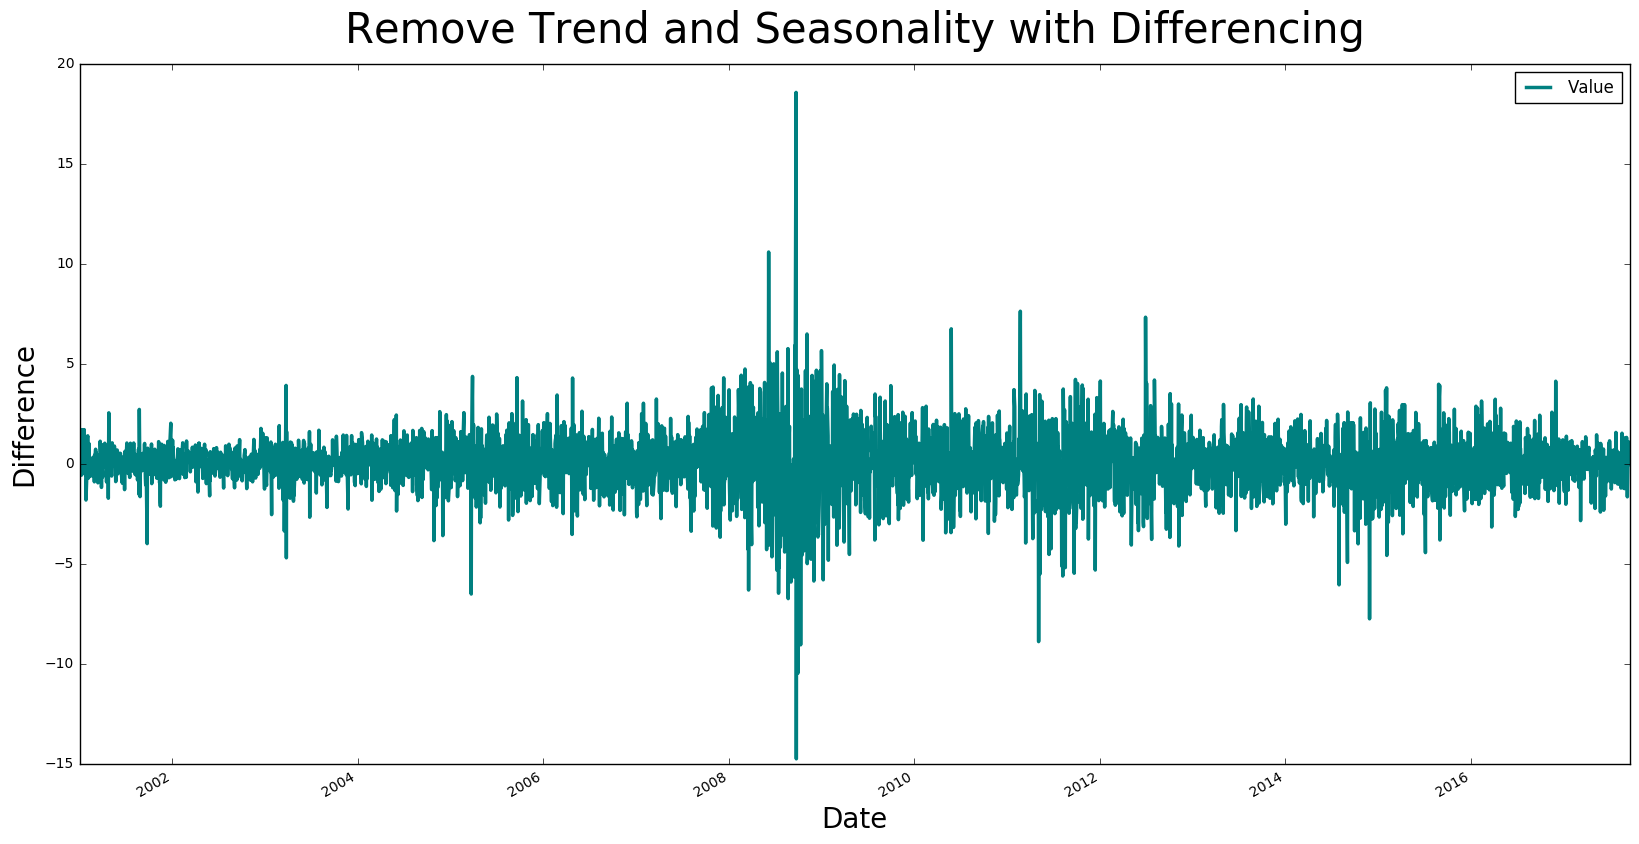

In [4]:
def get_difference(X):
    
    #Compute Difference
    d = X.diff()
    
    #Visualization
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    d.plot(lw=2.5,c='teal',ax=ax)
    ax.set_ylabel('Difference',fontsize=20)
    ax.set_xlabel('Date',fontsize=20)
    ax.set_title('Remove Trend and Seasonality with Differencing',fontsize=30,y=1.02)
    
    return(d)

data_diff = get_difference(data)
test_stationary(data_diff)

In [5]:
data_log = np.log(data)
test_stationary(data_log)

==== Dickey-Fuller Test ==== 
Test Statistic:  -1.76464241996
P-Value:  0.398151587733
Fail to Reject Null Hypothesis -- Conclude Time Series is Not Stationary


### ARIMA:

Now, let's apply ARIMA to forecast future WTI prices using this stationarized time series. First, a couple of notes on parameters of the ARIMA model:

- **P** -- The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable. For example, if p=2, it means that predictors of x(t) will be x(t-1) and x(t-2).

    - For an AR1 model, regression of a deviation on all previous deviations depends only on the most recent one. Hence, the term lag 1.


- **Q** -- The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation. For instance, if q=2, the predictors for x(t) will be e(t-1) and e(t-2) where e(i) is the difference between the moving average at i-th instant and the actual value. Or if q=5, then the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


- **D** -- The number of differences (d): These are the number of non-seasonal differences. Earlier, the difference consisted of d=1 period, thus this is called a first order differenced time series.

    - If d=0: $y_{t} = Y_{t}$
    - If d=1: $y_{t} = Y_{t} - Y_{t-1}$
    - If d=2: $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-1} -Y_{t-2})$ == $Y_{t} -2Y_{t-1} + Y_{t-2}$

Note: the second difference of Y is *not* the difference from 2 periods ago. Instead, it is the first-difference-of-the-first difference, which is the discrete analog of a second derivative, or can be thought of as the local acceleration of the series rather than its local trend.

**ARIMA(1,1,0) = Differenced 1st Order Autoregressive Model**


- $\hat{Y_{t}} = \mu + Y_{t-1} + \phi_{1}(Y_{t-1} - Y_{t-2})$

**Autocorrelation Function (ACF)**

- Measurement of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points). So, the ACF describes the correlation between outcomes separated by various time lags. To determine the value of P, we can examine the ACF vs lags in the figure below of the differenced time series. The first instance where the ACF value is inverted, rule of thumb is to then take the first previous lag value for 'p'.

**Partial Autocorrelation Function (PACF)** 

- Measurement of the correlation between the timeseries with a lagged version of itself after eliminating the variations already explained by the intervening comparisons. Example -- at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

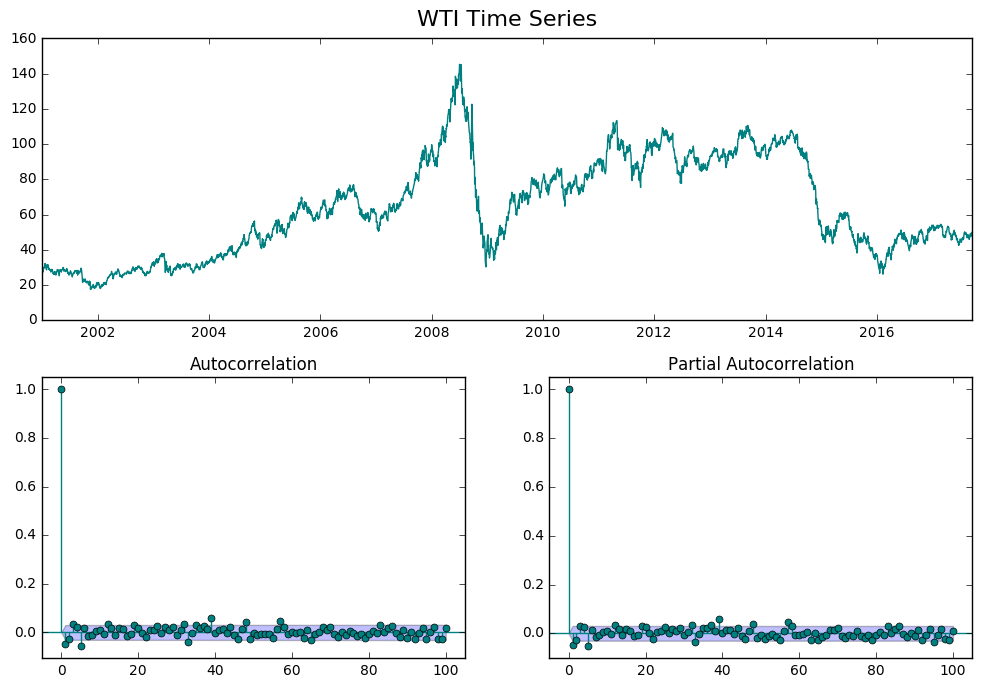

In [6]:
def tsplot(raw,transform,lags=100):
    
    fig = plt.figure(figsize=(12,8))    
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    ts_ax.plot(raw,color='teal')
    smt.graphics.plot_acf(transform.ix[:,0].dropna(),lags=lags,ax=acf_ax,color='teal')
    smt.graphics.plot_pacf(transform.ix[:,0].dropna(),lags=lags,ax=pacf_ax,color='teal')
    
    ts_ax.set_title('WTI Time Series',fontsize=16,y=1.02)
    
tsplot(data,data_diff)

### Fit ARIMA Model and Explore Statistical Summary

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2945
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -5529.339
Method:                       css-mle   S.D. of innovations              1.582
Date:                Tue, 26 Sep 2017   AIC                          11066.678
Time:                        16:24:03   BIC                          11090.630
Sample:                    01-03-2001   HQIC                         11075.302
                         - 09-26-2012                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.0213      0.027      0.790      0.430        -0.032     0.074
ar.L1.D.Value    -0.0440      0.018     -2.392      0.017        -0.080    -0.008
ar.L2.D.Value    -0.0378      0.018     

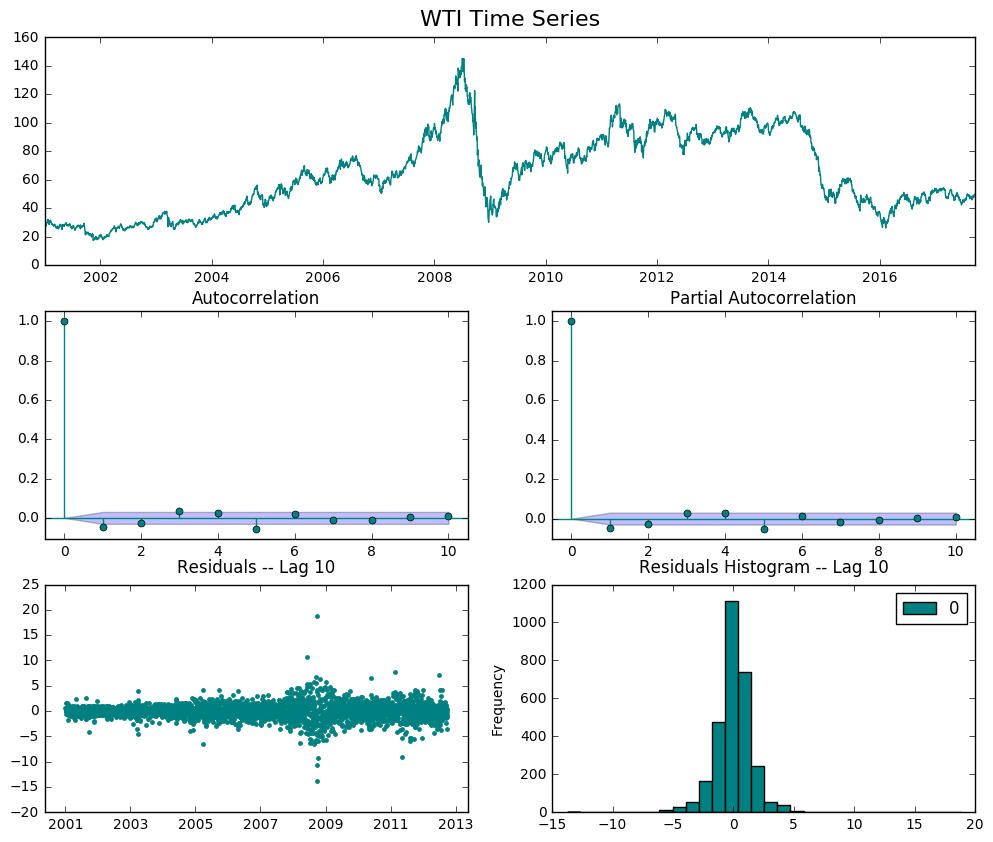

In [7]:
def split_train_testing(y,train_size=0.70): 
    
    size = int(len(y) * train_size)
    y_train, y_test = y[0:size], y[size:len(y)]
    
    return(y_train,y_test)

def tsplot_summary(raw,residuals,lags):
    
    #Difference
    raw_diff = raw.diff().dropna()
    
    #Setup Grid Plot
    fig = plt.figure(figsize=(12,10))    
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    res_ax = plt.subplot2grid(layout, (2, 0))
    res_hist_ax = plt.subplot2grid(layout, (2, 1))
    
    #Original Time Series
    ts_ax.plot(raw,color='teal')
    ts_ax.set_title('WTI Time Series',fontsize=16,y=1.02)
    
    #ACF and PACF plots
    smt.graphics.plot_acf(raw_diff.ix[:,0],lags=lags,ax=acf_ax,color='teal')
    smt.graphics.plot_pacf(raw_diff.ix[:,0],lags=lags,ax=pacf_ax,color='teal')
    
    #Residual Plot
    res_ax.scatter(residuals.index,residuals,color='teal',s=6)
    res_ax.set_title('Residuals -- Lag {}'.format(lags),fontsize=12,y=1.02)
    
    #Residual Histogram
    residuals.plot(kind='hist',bins=30,color='teal',ax=res_hist_ax)
    res_hist_ax.set_title('Residuals Histogram -- Lag {}'.format(lags),fontsize=12,y=1.02)

def train_ARIMA(data,lags):
    
    #Get Train/Test Data
    y_train,y_test = split_train_testing(data)
    
    model = smt.ARIMA(y_train, order=(lags,1,0))
    model_fit = model.fit(disp=0)
    
    #Residuals
    residuals = pd.DataFrame(model_fit.resid)
    
    #Summary Statistics:
    print(model_fit.summary())

    #Residual Statistics
    print(residuals.describe())
    
    tsplot_summary(data,residuals,lags=10)
    
    return(model_fit)
    
if __name__ == '__main__':
    
    #PARAMETERS
    lags=2
    
    #TRAIN ARIMA
    m = train_ARIMA(data,lags)

### Forecast

Average MSE:  1.55900976984
Length of Forecast:  90 Days


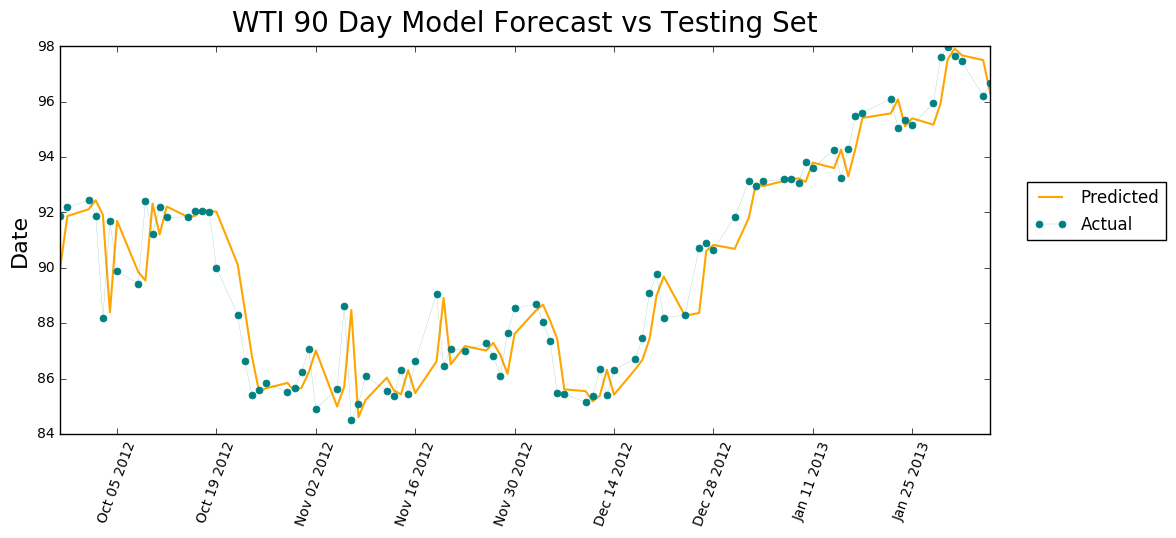

In [16]:
def forecast_timeseries(data,steps=2):
    
    #Get Train/Test Data
    y_train,y_test = split_train_testing(data)
    
    #Store History to a list
    history = y_train.values.tolist()

    #Store predictions/MSE
    predictions = []
    mse = []

    #Step-Forward Predictions
    for i in range(steps):
        
        #Train ARIMA Model p,q,d
        model = smt.ARIMA(history, order=(2,1,0))
        model_fit = model.fit(disp=0)

        #Predict next value (walk forward)
        yhat = model_fit.forecast()[0]

        #Ground Truth
        y_true = y_test.ix[i,:]

        #Append History/Predictions
        predictions.append(yhat)

        #Concatenate History with current prediction index
        history.append(y_true)

        #Mean Squared Error
        mse.append(mean_squared_error(yhat,y_true))

    print('Average MSE: ',np.mean(mse))
    print('Length of Forecast: ',len(predictions),'Days')
    
    #Concatenate Results to DataFrame
    pred = pd.DataFrame(predictions,columns=['Predicted'])
    hist = pd.DataFrame(history[-steps:]).reset_index(drop=False)
    
    results = pd.merge(pred,hist,left_index=True,right_index=True,how='outer').set_index('index')
    return(results)
    
def predictions_plot(df,forecast):
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    
    ax.plot(df.ix[:,'Predicted'],c='orange',lw=1.5,label='Predicted')
    ax.plot(df.ix[:,'Value'],lw=0.1,color='teal',label='Actual',marker='.',markersize=10)
    ax.set_ylabel('WTI Price Index (USD)',fontsize=16)
    ax.set_ylabel('Date',fontsize=16)
    ax.set_title('WTI {} Day Model Forecast vs Testing Set'.format(forecast),fontsize=20,y=1.02)
    ax.legend(loc=(1.04,.50))
    plt.xticks(rotation=70)
    
    
if __name__ == '__main__':
    forecast = 90
    results = forecast_timeseries(data,forecast)
    predictions_plot(results,forecast)

Feature Shape:  (2943, 3)
Target Shape:  (2943,)
Mean Squared Error:  0.43


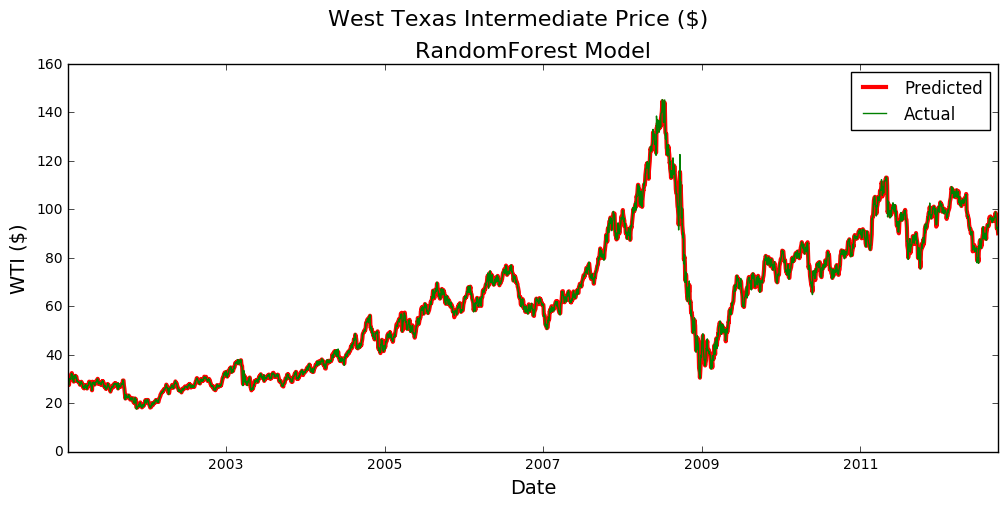

In [50]:
from sklearn.ensemble import RandomForestRegressor

def convert_to_supervised(df,lag):
    
    #Input Data
    d = pd.DataFrame(df)
    
    #Shift DataFrame
    shifted = pd.concat([d.shift(i) for i in range(1,lag+1)],axis=1)

    #Concatenate shifted dataframe with target values
    out = pd.concat([shifted,d],axis=1)
    cols = ['t{}'.format(i) for i in range(1,lag+1)]
    cols += ['y']
    out.columns = cols
    return(out)
    

def train_rf_visual(true,pred):
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    ax.plot(true.index,pred,color='r',lw=3,label='Predicted')
    ax.plot(true,color='green',lw=1,label='Actual')
    ax.set_ylabel('WTI ($)',fontsize=14)
    ax.set_xlabel('Date',fontsize=14)
    ax.legend()
    plt.suptitle('West Texas Intermediate Price ($)',fontsize=16,y=1.01)
    plt.title('RandomForest Model',fontsize=16)

def train_random_forest(data,lag):
    
    #Split Data into Train/Test
    y_train,y_test = split_train_testing(data)
    
    #Format problem as supervised learning
    d = convert_to_supervised(y_train,lag).dropna()

    #Each Lag Instance is new "X
    X_train = d.ix[:,:-1]
    
    #True Label from Training Set
    y_train = d.ix[:,-1]
    
    print('Feature Shape: ',X_train.shape)
    print('Target Shape: ',y_train.shape)

    #Train Random Forest
    reg = RandomForestRegressor(n_estimators=100)
    
    #Fit and Predict
    reg.fit(X_train,y_train)
    pred = reg.predict(X_train)

    #MSE
    print("Mean Squared Error: ",round(mean_squared_error(pred,y_train),3))
    
    #Get Visualization
    train_rf_visual(y_train,pred)
    
train_random_forest(data,3)